In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torchvision.models as models
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

/home/bami/anaconda3/envs/MIS/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bami/anaconda3/envs/MIS/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dir = '/data/nas2/KJA/MIS/'

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import cv2

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = models.densenet161(pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove classification head

        self.fc1 = nn.Linear(2210, 1024)  # 2208 features + 2 Hu moments
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)

    def extract_hu_moments(self, img):
        binary = img[:][0] > 1
        binary = binary.astype(np.uint8)
        moments = cv2.moments(binary)
        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        hu_selected = np.array([hu_moments[2], hu_moments[6]])
        return hu_selected

    def forward_once(self, x):
        batch_size = x.shape[0]
        x_np = x.permute(0, 2, 3, 1).cpu().numpy()
        hu_moments_batch = [self.extract_hu_moments(img) for img in x_np]
        hu_moments_tensor = torch.tensor(hu_moments_batch, dtype=torch.float32, device=x.device)

        x = self.cnn.features(x)  # (B, 2208, 7, 7)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)  # (B, 2208)
        x = torch.cat((x, hu_moments_tensor), dim=1)  # (B, 2210)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.fc6(x)
        x = self.dropout(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((label * torch.pow(euclidean_distance, 2) +
                          (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)))
        return loss

In [5]:
model_paths = ['Siamese_AAAB_LIDC1.pth', 'Siamese_BBBC_LIDC1.pth','Siamese_AAAC_LIDC1.pth' ]
model_list = []

In [6]:
thresholds = [-0.2205, -0.2010, -0.1728]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for path in model_paths:
    model = SiameseNetwork()  # initialize the model
#     model = torch.nn.DataParallel(model)  # wrap with DataParallel
    model.load_state_dict(torch.load(path))  # load weights
    model.to(device)
    model.eval()
    model_list.append(model)

/home/bami/anaconda3/envs/MIS/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bami/anaconda3/envs/MIS/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def collect_test(img_dir, label):
    file_names = sorted(f for f in os.listdir(img_dir) if f != '@eaDir')
    img_paths = [os.path.join(img_dir, f.replace('.jpg', '.jpg')) for f in file_names]
    return list(zip(img_paths, [label] * len(file_names)))

# Define your mistake-test folders
test_dataset =[]

test_dataset += collect_test(
    dir + "/LIDC dataset/A_test/",
    "A"
)

test_dataset += collect_test(
    dir + "/LIDC dataset/B_test/",
    "B"
)

test_dataset += collect_test(
    dir + "/LIDC dataset/C_test/",
    "C"
)

In [9]:
test_dataset =  test_dataset[0:2125]+test_dataset[6375:8500]+test_dataset[12750:14875]

In [15]:
len(test_dataset)

6375

In [16]:
def build_support_tensor(img_path):
    img = Image.open(img_path).convert('L')     # [1, H, W] # still [1, H, W]
    img = np.array(img)
    combined = np.stack([img, img, img], axis=-1)     # [3, H, W]

    combined = Image.fromarray(combined)
    combined = few_transform(combined)
    return combined

In [17]:
few_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
import os

img_dir = os.path.join(dir, 'LIDC dataset/A/')

A_images_list = []

for mask_filename in sorted(os.listdir(img_dir)):
    if not mask_filename.endswith('.png'):
        pass
    base_name = os.path.splitext(mask_filename)[0]  # remove .png
    img_filename = base_name + '.png'
    img_path = os.path.join(img_dir, img_filename)
    
    if os.path.exists(img_path):
        A_images_list.append(img_path)
    else:
        print(f"❗ Warning: No matching image found for {mask_filename}")

# Build A_test tensors
A_tests = []
for A_img in A_images_list:
    A_test = build_support_tensor(A_img).unsqueeze(0)
    A_tests.append(A_test)

In [20]:
img_dir = os.path.join('/data/nas2/KJA/MIS/', 'LIDC dataset/B/')

B_images_list = []

for mask_filename in sorted(os.listdir(img_dir)):
    if not mask_filename.endswith('.png'):
        pass
    base_name = os.path.splitext(mask_filename)[0]  # remove .png
    img_filename = base_name + '.png'
    img_path = os.path.join(img_dir, img_filename)
    
    if os.path.exists(img_path):
        B_images_list.append(img_path)
    else:
        print(f"❗ Warning: No matching image found for {mask_filename}")

# Build A_test tensors
B_tests = []
for B_img in B_images_list:
    B_test = build_support_tensor(B_img).unsqueeze(0)
    B_tests.append(B_test)

In [21]:
A_refs_final =A_tests[:50]
B_refs_final =B_tests[:50]

In [22]:
results_AB = []

# Step 1: Pre-batch A_refs
A_ref_batch = torch.stack([ref.to(device) for ref in A_refs_final])  # (N_refs, C, H, W)
if A_ref_batch.dim() == 5 and A_ref_batch.shape[1]==1:
        A_ref_batch = A_ref_batch.squeeze(1)

model = model_list[0]
threshold = thresholds[0]

with torch.no_grad():
    for img_path, true_label in tqdm(test_dataset, desc="Predicting styles"):
        query_tensor = build_support_tensor(img_path).unsqueeze(0).to(device)
        query_batch = query_tensor.repeat(A_ref_batch.size(0), 1, 1, 1)  # (N_refs, C, H, W)
        if query_batch.dim() == 5 and query_batch.shape[1] == 1:
                query_batch = query_batch.squeeze(1)

        # Batched forward pass
        output1, output2 = model(A_ref_batch, query_batch)
        squared_distances = torch.pow(F.pairwise_distance(output1, output2), 2)  # (N_refs,)

        mean_score = squared_distances.mean().item()
        pred = -mean_score > threshold
        style_pred = "A" if pred else "B"

        result = {
            'img_path': img_path,
            'true_label': true_label,
            'score': mean_score,
            'pred': style_pred
        }
        results_AB.append(result)


Predicting styles:   0%|                                     | 0/6375 [00:00<?, ?it/s]/tmp/ipykernel_34027/1389646898.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/torch/csrc/utils/tensor_new.cpp:274.)
  hu_moments_tensor = torch.tensor(hu_moments_batch, dtype=torch.float32, device=x.device)
Predicting styles: 100%|████████████████████████| 6375/6375 [1:08:48<00:00,  1.54it/s]


In [23]:
results_AB[-600:]

[{'img_path': '/data/nas2/KJA/MIS//LIDC dataset/C_test/LIDC-IDRI-0211_nodule-0_slice-9.png',
  'true_label': 'C',
  'score': 0.027870630845427513,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/C_test/LIDC-IDRI-0213_nodule-0_slice-0.png',
  'true_label': 'C',
  'score': 0.06100873276591301,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/C_test/LIDC-IDRI-0213_nodule-0_slice-1.png',
  'true_label': 'C',
  'score': 0.03367504104971886,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/C_test/LIDC-IDRI-0213_nodule-0_slice-2.png',
  'true_label': 'C',
  'score': 0.06844344735145569,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/C_test/LIDC-IDRI-0213_nodule-0_slice-3.png',
  'true_label': 'C',
  'score': 0.028416380286216736,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/C_test/LIDC-IDRI-0213_nodule-0_slice-4.png',
  'true_label': 'C',
  'score': 0.027067413553595543,
  'pred': 'A'},
 {'img_path': '/data/nas2

In [24]:
results_AC = []

dataset_AC = [
    (res['img_path'], res['true_label'])
    for res in results_AB
    if res['pred'] == 'A'
]

A_ref_batch = torch.stack([ref.to(device) for ref in A_refs_final])  # (N_refs, C, H, W)
if A_ref_batch.dim() == 5 and A_ref_batch.shape[1]==1:
        A_ref_batch = A_ref_batch.squeeze(1)

model = model_list[2]
threshold = thresholds[2]

with torch.no_grad():
    for img_path, true_label in tqdm(dataset_AC, desc="Predicting styles"):
        # Step 2: Build query and batch it
        query_tensor = build_support_tensor(img_path).unsqueeze(0).to(device)
        query_batch = query_tensor.repeat(A_ref_batch.size(0), 1, 1, 1)  # (N_refs, C, H, W)
        if query_batch.dim() == 5 and query_batch.shape[1] == 1:
                query_batch = query_batch.squeeze(1)

        # Step 3: Run batched inference
        output1, output2 = model(A_ref_batch, query_batch)
        squared_distances = torch.pow(F.pairwise_distance(output1, output2), 2)

        # Step 4: Compute mean distance and classify
        mean_score = squared_distances.mean().item()
        pred = -mean_score > threshold
        style_pred = "A" if pred else "C"

        result = {
            'img_path': img_path,
            'true_label': true_label,
            'score': mean_score,
            'pred': style_pred
        } 
        results_AC.append(result)

Predicting styles: 100%|██████████████████████████| 4213/4213 [42:59<00:00,  1.63it/s]


In [25]:
results_AC

[{'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-1_slice-2.png',
  'true_label': 'A',
  'score': 0.016591917723417282,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-1_slice-3.png',
  'true_label': 'A',
  'score': 0.02271885797381401,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-3_slice-0.png',
  'true_label': 'A',
  'score': 0.021225914359092712,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-3_slice-2.png',
  'true_label': 'A',
  'score': 0.018509922549128532,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-4_slice-0.png',
  'true_label': 'A',
  'score': 0.017018189653754234,
  'pred': 'A'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-4_slice-2.png',
  'true_label': 'A',
  'score': 0.035952210426330566,
  'pred': 'A'},
 {'img_path': '/data/na

In [26]:
results_BC = []

dataset_BC = [
    (res['img_path'], res['true_label'])
    for res in results_AB
    if res['pred'] == 'B'
]

model = model_list[1]
threshold = thresholds[1]

B_ref_batch = torch.stack([ref.to(device) for ref in B_refs_final])  # (N_refs, C, H, W)
if B_ref_batch.dim() == 5 and B_ref_batch.shape[1]==1:
        B_ref_batch = B_ref_batch.squeeze(1)

with torch.no_grad():
    for img_path, true_label in tqdm(dataset_BC, desc="Predicting styles"):
        # Step 2: Build query and batch it
        query_tensor = build_support_tensor(img_path).unsqueeze(0).to(device)
        query_batch = query_tensor.repeat(B_ref_batch.size(0), 1, 1, 1)  # (N_refs, C, H, W)
        if query_batch.dim() == 5 and query_batch.shape[1] == 1:
                query_batch = query_batch.squeeze(1)

        # Step 3: Run batched inference
        output1, output2 = model(B_ref_batch, query_batch)
        squared_distances = torch.pow(F.pairwise_distance(output1, output2), 2)

        # Step 4: Compute mean distance and classify
        mean_score = squared_distances.mean().item()
        pred = -mean_score > threshold
        style_pred = "B" if pred else "C"

        result = {
            'img_path': img_path,
            'true_label': true_label,
            'score': mean_score,
            'pred': style_pred
        }
        results_BC.append(result)

Predicting styles: 100%|██████████████████████████| 2162/2162 [21:44<00:00,  1.66it/s]


In [27]:
results_BC

[{'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-3_slice-1.png',
  'true_label': 'A',
  'score': 0.004128501750528812,
  'pred': 'B'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-4_slice-1.png',
  'true_label': 'A',
  'score': 0.004265390336513519,
  'pred': 'B'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0016_nodule-5_slice-7.png',
  'true_label': 'A',
  'score': 0.004448725841939449,
  'pred': 'B'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0017_nodule-0_slice-1.png',
  'true_label': 'A',
  'score': 0.004140827339142561,
  'pred': 'B'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0017_nodule-0_slice-4.png',
  'true_label': 'A',
  'score': 0.003930312115699053,
  'pred': 'B'},
 {'img_path': '/data/nas2/KJA/MIS//LIDC dataset/A_test/LIDC-IDRI-0018_nodule-3_slice-4.png',
  'true_label': 'A',
  'score': 0.050032518804073334,
  'pred': 'B'},
 {'img_path': '/data/n

In [28]:
final_result = results_BC+results_AC

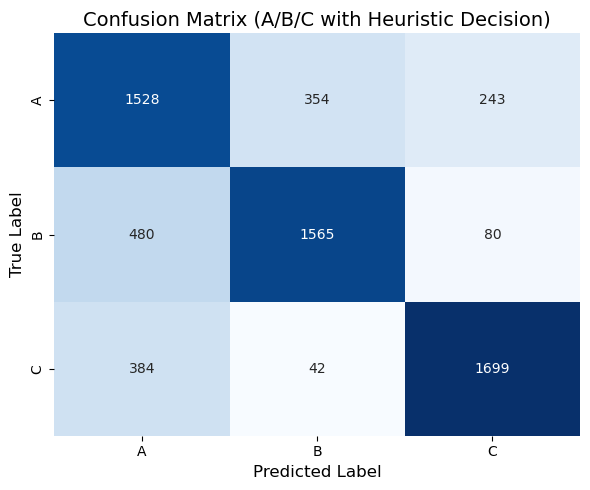

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix


final_true_labels = []
final_pred_labels = []

for data in final_result:
    final_true_labels.append(data['true_label'])
    final_pred_labels.append(data['pred'])
    
# === Assumptions ===
# results_AB, results_BC = list of dicts like:
#   {'img_path': ..., 'true_label': ..., 'pred': ..., 'score': ...}
# thresholds = [threshold_AB, threshold_BC]

# Setup index from img_path for lookup
# ab_dict = {res['img_path']: res for res in results_AB}
# bc_dict = {res['img_path']: res for res in results_BC}

# threshold_ab = thresholds[0]
# threshold_bc = thresholds[1]

# final_true_labels = []
# final_pred_labels = []

# # Merge by image paths
# all_paths = set(ab_dict.keys()).union(bc_dict.keys())

# for path in all_paths:
#     ab = ab_dict.get(path)
#     bc = bc_dict.get(path)

#     true_label = (ab or bc)['true_label']

#     if ab and not bc:
#         final_pred = ab['pred']

#     elif bc and not ab:
#         final_pred = bc['pred']

#     elif ab and bc:
#         pred_ab = ab['pred']
#         pred_bc = bc['pred']

#         if pred_ab == 'A':
#             final_pred = 'A'
#         elif pred_ab == 'B' and pred_bc == 'B':
#             final_pred = 'B'
#         elif pred_ab == 'B' and pred_bc == 'C':
#             ab_diff = abs(ab['score'] - threshold_ab)
#             bc_diff = abs(bc['score'] - threshold_bc)
#             final_pred = 'B' if ab_diff > bc_diff else 'C'
#         else:
#             raise ValueError(f"Unexpected prediction combo: AB={pred_ab}, BC={pred_bc}")
#     else:
#         continue  # Skip if neither exists (shouldn't happen)

#     final_true_labels.append(true_label)
#     final_pred_labels.append(final_pred)



# === Build confusion matrix ===
labels = ['A', 'B', 'C']
cm = confusion_matrix(final_true_labels, final_pred_labels, labels=labels)

# === Plot using seaborn ===
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix (A/B/C with Heuristic Decision)", fontsize=14)
plt.tight_layout()
plt.show()
